<a href="https://colab.research.google.com/github/10618610/Curso-de-deep-learning/blob/main/C%C3%B3pia_de_Notebook_of_CARLA2022_paper_Physics_Aware_Neural_Networks_for_Parametric_Studies_in_Linear_Boundary_Layer_Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

First of all, we setup the TensorFlow computation enviroment. We use PhiFlow for simplifying the autodiff expressions.

# Physics-Aware Neural Networks for Parametric Studies with PDEs

In this notebook, we illustrate physics informed neural networks (PINNs) applied to parametric studies. By "parametric studies" we mean to explore the patterns that arise in the solution of PDEs when one or more of their coefficients vary their values from one specific model instance to the other.



In [ ]:
!pip install --quiet phiflow==1.5.1

     |████████████████████████████████| 2.7 MB 4.3 MB/s 


In [ ]:
# Import libs
import math
from time import time
import random
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from phi.tf.flow import *
from mpl_toolkits.mplot3d import Axes3D
from keras.layers.core import Activation
from keras.utils.generic_utils import get_custom_objects
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

tf.compat.v1.enable_eager_execution()

tf.random.set_random_seed(39)
np.random.seed(39)
random.seed(39)

# Set data type
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)

# Neural network setup

We assume a feedforward neural network of the following structure:
- the input is scaled elementwise to lie in the interval $[0,1]$,
- followed by `num_hidden_layers` fully connected layers (default=4) each containing `num_neurons_per_layer` neurons (default=24) and each followed by a hyperbolic tangent activation function,
- one fully connected output layer.

In [ ]:
def init_NN(num_inputs=3, num_hidden_layers=4, num_neurons_per_layer=24, num_outputs=1):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(num_inputs))

    # Introduce a scaling layer to map input to [lb, ub]
    #scaling_layer = tf.keras.layers.Lambda( lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    #model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, #activation='custom_activation',
                                         activation=tf.keras.activations.get('tanh'),
                                         kernel_initializer='glorot_normal'))

    model.add(tf.keras.layers.Dense(num_outputs))

    #####scaling_layer = tf.keras.layers.Lambda( lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)

    return model

# Some utility operations

In [ ]:
def diff(U, U_ex):
  n = len(U)

  dif = [None]*n

  for i in range( n ):
    dif[i] =  np.abs(np.subtract(U[i], U_ex[i]))

  return dif

In [ ]:
def compute_generalization_error(U, U_ex):

    L2_test = np.sqrt(np.mean((U_ex - U) ** 2))
    print("Error Test 1:", L2_test)

    rel_L2_test = L2_test / np.sqrt(np.mean(U_ex ** 2))
    print("Relative Error Test 1 :", rel_L2_test)

    L2_test1 = np.mean(np.abs(U_ex - U))
    print("Error Test 2 :", L2_test1)

    rel_L2 = np.sqrt(np.sum(np.power(U-U_ex, 2)) / np.sum(np.power(U_ex,2)))
    print("Relative Error Test 2:", rel_L2)


    mse = mean_squared_error(U_ex, U)
    print("MSE:", mse)
    dif = diff(U, U_ex)
    max_dif  = np.max(dif)
    min_dif  = np.min(dif)
    print("Max:", max_dif)
    print("Min:", min_dif)
    evs = explained_variance_score(U,U_ex)
    print("Explained Variance Score:", evs)

    plt.figure()
    plt.grid(True, which="both", ls=":")
    plt.plot(U_ex,U,'.', color="blue")
    plt.plot(U_ex,U_ex ,'.', color="red")
    plt.xlabel(r'Exact Values')
    plt.ylabel(r'Predicted Values')


# The reaction-advection-diffusion problem

Our first case study will involve the PDE problem as presented in
:
* HARDER, Christopher; PAREDES, Diego; VALENTIN, Frédéric. On a multiscale hybrid-mixed method for advective-reactive dominated problems with heterogeneous coefficients. Multiscale Modeling & Simulation, v. 13, n. 2, p. 491-518, 2015.

We describe the PINN approach for approximating the solution $u \in H^1(\Omega)$ of the following reaction-advection-diffusion problem:

\begin{equation*}
\begin{cases}
\begin{aligned}
    \nabla \cdot (- \mathcal{K} \nabla u + \alpha u) + \sigma u &= 1 \text{  in }  \Omega,\\
    u &= 0 \text{  on } \partial \Omega_D, \\
    \nabla u \cdot \mathbf{n} &= 0 \text{  on } \partial \Omega_N,
\end{aligned}
\end{cases}
\end{equation*}

with $\Omega$ being a unit square domain, $\partial \Omega_D$ corresponding to the boundaries $x = (0, y)$ and $x = (1, y)$, with $y \in (0, 1)$ and $\partial \Omega_N = \partial \Omega \backslash \partial \Omega_D$.

We also set $\alpha := (a, 0)^T$ and $\mathcal{K} :=  k \mathcal{I} $, where $\mathcal{I}$ is the identity matrix and $a$, $k$, $\sigma \in \mathbb{R}$.

## First test case:

Let $\sigma = 1$ and $a = 0$. The solution reads:

\begin{equation*}
    u(x,y) = \dfrac{\sinh( \dfrac{\sqrt{4k}}{2k}(x-1)) - \sinh(\dfrac{\sqrt{4k}}{2k} x)}{\sinh(\dfrac{\sqrt{4k}}{2k})} +1
\end{equation*}

## Second test case:

Let $\sigma=0$ and $a\not = 0$

\begin{equation*}
u(x,y)=\frac{1}{a} \left( x- \frac{\sinh(\frac{a}{2k}x)}{\sinh(\frac{a}{2k})}e^{\frac{a}{2k}(x-1)}\right)
\end{equation*}

## General test case:

Here $\sigma > 0$ and $a\not = 0$

\begin{equation*}
 u(x,y):=\frac{1}{\sigma} \Big(\frac{\sinh(\frac{\sqrt{a^2+4 k\sigma}}{2 k}(x-1))}{\sinh(\frac{\sqrt{a^2+4 k\sigma}}{2 k})} e^{\frac{a}{2 k}x}- \frac{\sinh(\frac{\sqrt{a^2+4 k\sigma}}{2 k}x)}{\sinh(\frac{\sqrt{a^2+4 k\sigma}}{2 k})}e^{\frac{a}{2 k}(x-1)} + 1\Big)\,.
\end{equation*}


Our interest is in assessing whether a PINN can capture the relationship between $u$ and $k$ when $u$ is unknown.

## Model problem

We define a model class that encapsulates functions for computing the residuals of the loss function. We use "duck typing", so that the remainder of the code may be reused for other problems provided that their corresponding model classes follow the same interface as RAD.

In [ ]:
class RAD:
  # Object constructor
  def __init__(self, NN, optim=None):
    self.NN = NN
    self.sigma = 1.
    self.f = 1.
    self.alphax = 0.
    self.alphay = 0.
    self.optim = optim

  # Define residual of the PDE
  def get_r(self, X_r):
    k, x, y =  X_r[:, 0:1], X_r[:, 1:2], X_r[:,2:3]

    u = self.NN(tf.stack([k[:,0], x[:,0], y[:,0]], axis=1))

    u_x = gradients(u, x)
    u_y = gradients(u, y)
    u_xx = gradients(u_x, x)
    u_yy = gradients(u_y, y)

    lap_u = u_xx + u_yy

    res_u_r = self.f + k*lap_u - self.alphax * u_x - self.alphay * u_y - self.sigma * u

    return res_u_r

  # Define residual of Neumann BC
  def get_n(self, X_data_n, u_data_n):
    k, x, y =  X_data_n[:, 0:1], X_data_n[:, 1:2], X_data_n[:,2:3]

    u = self.NN(tf.stack([k[:,0], x[:,0], y[:,0]], axis=1))

    u_y = gradients(u, y)

    res_u_n = u_y - u_data_n

    return res_u_n

  # Define residual of Dirichlet BC
  def get_d(self, X_data, u_data):
    return u_data - self.NN(X_data)

  def compute_loss(self, X_r, X_data, u_data, X_data_n, u_data_n):

    # Compute error in the interior
    r = self.get_r(X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Compute error in the boundary neumann
    bd_n = self.get_n(X_data_n, u_data_n)
    phi_n = tf.reduce_mean(tf.square(bd_n))

    # Compute error in the boundary dirichlet
    bd_d = self.get_d(X_data, u_data)
    phi_b = tf.reduce_mean(tf.square(bd_d))

    loss0 = 2.0*phi_r
    loss1 = 1.0*phi_b
    loss2 = 1.0*phi_n

    return [loss0, loss1, loss2]

  def get_grad(self, X_r, X_data_d, u_data_d, X_data_n, u_data_n):

    with tf.GradientTape(persistent=True) as tape:
      # This tape is for derivatives with
      # respect to trainable variables
      tape.watch(model.NN.trainable_variables)
      loss = self.compute_loss(X_r, X_data_d, u_data_d, X_data_n, u_data_n)

    g = tape.gradient(loss, self.NN.trainable_variables)
    del tape

    return loss, g

  def set_optimizer(self, optim):
    self.optim = optim

  # Define one training step as a TensorFlow function to increase speed of training
  @tf.function
  def train_step(self, data_list):
    assert self.optim != None, "No optimizer has been configured!"

    X_r_train, X_data_d_train, u_data_d_train, X_data_n_train, u_data_n_train = data_list

    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = self.get_grad(X_r_train, X_data_d_train, u_data_d_train, X_data_n_train, u_data_n_train)

    # Perform gradient descent step
    self.optim.apply_gradients(zip(grad_theta, self.NN.trainable_variables))

    return loss

## Generate a set of collocation points

We will randomly choose points within the interior of domain $\Omega$ and also on its boundaries $\partial\Omega_D$ and $\partial\Omega_N$. First, however, we define the distribution of the randomly generated $k$ samples as their amount will guide the generation of the training data.

In [ ]:
k_array = np.array([])

for i in tf.random.uniform((3,1), 0.01, 0.001, dtype=DTYPE):
  k_variable =  i.numpy()
  k_array = np.concatenate([k_array, k_variable])

#for i in tf.random.uniform((4,1), 0.01, 0.1, dtype=DTYPE):
#  k_variable =  i.numpy()
#  k_array = np.concatenate([k_array, k_variable])

#for i in tf.random.uniform((4,1), 0.001, 0.01, dtype=DTYPE):
#  k_variable =  i.numpy()
#  k_array = np.concatenate([k_array, k_variable])

#for i in tf.random.uniform((4,1), 0.0001, 0.001, dtype=DTYPE):
#  k_variable =  i.numpy()
#  k_array = np.concatenate([k_array, k_variable])

#for i in tf.random.uniform((4,1), 0.00001, 0.0001, dtype=DTYPE):
#  k_variable =  i.numpy()
#  k_array = np.concatenate([k_array, k_variable])

print(k_array)

[0.00183151 0.00692988 0.00282557]


In [ ]:
#### Set number of data points
N_b_x = 100
N_b_y = 100
N_r = 200

# Define boundary condition Dirichlet
def fun_u_b(x, y):
  n = x.shape[0]
  return tf.zeros((n,1), dtype=DTYPE)

# Define boundary condition Neummann
def fun_u_b_n(u_x, u_y):
  n = u_x.shape[0]
  return (tf.zeros((n,1), dtype=DTYPE))

#### Set boundary
xmin = 0.
xmax = 1.
ymin = 0.
ymax = 1.

#### Lower bounds
lb = tf.constant([xmin, ymin], dtype=DTYPE)
#### Upper bounds
ub = tf.constant([xmax, ymax], dtype=DTYPE)

#### Boundary data

### Define array with k
##horizontal x = 1 e x = 0
x_1b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b_x,1), 0.5, dtype=DTYPE)
y_1b = tf.random.uniform((N_b_x,1), lb[1], ub[1], dtype=DTYPE)
# Evaluate boundary condition at (x_1b,y_1b)- x=0
u_1b = fun_u_b(x_1b, y_1b).numpy()

##vertical
x_2b = tf.random.uniform((N_b_y,1), lb[0], ub[0], dtype=DTYPE)
y_2b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b_y,1), 0.5, dtype=DTYPE)
# Evaluate boundary condition at at (x_2b,y_2b)- vertical
u_2b = fun_u_b_n(x_2b, y_2b).numpy()


#### Draw uniformly sampled collocation points
x_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
y_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)


################# training data #################
#build inputs
cont = 0
X_data_d_train = np.array([[0]*3])
u_data_d_train = np.array([[0]*1])
X_data_n_train = np.array([[0]*3])
u_data_n_train = np.array([[0]*1])
X_r_train = np.array([[0]*3])

for i in k_array:
  k_var =  i /1.
  cont = cont +1

  ### Define array with k
  ##horizontal
  tensor_k = tf.fill([N_b_x,1], k_var)
  X_1b = tf.concat([tensor_k, x_1b, y_1b], axis=1).numpy()

  ### Define array with k
  ## vertical
  tensor_k = tf.fill([N_b_y,1], k_var)
  X_2b = tf.concat([tensor_k, x_2b, y_2b], axis=1).numpy()

  ### Define array with k
  ## points inside a domain
  tensor_k = tf.fill([N_r,1], k_var)
  X_r = tf.concat([tensor_k,x_r, y_r], axis=1).numpy()


  #### Collect data in lists
  X_data_d_train = np.concatenate([X_data_d_train, X_1b])
  u_data_d_train = np.concatenate([u_data_d_train, u_1b])
  X_data_n_train = np.concatenate([X_data_n_train, X_2b])
  u_data_n_train = np.concatenate([u_data_n_train, u_2b])
  X_r_train = np.concatenate([X_r_train, X_r])

X_data_d_train = np.delete(X_data_d_train, 0, 0)
u_data_d_train = np.delete(u_data_d_train, 0, 0)
X_data_n_train = np.delete(X_data_n_train, 0, 0)
u_data_n_train = np.delete(u_data_n_train, 0, 0)
X_r_train = np.delete(X_r_train, 0, 0)

X_data_d_train = tf.convert_to_tensor(X_data_d_train, dtype=DTYPE)
X_data_n_train = tf.convert_to_tensor(X_data_n_train,dtype=DTYPE)
X_r_train = tf.convert_to_tensor(X_r_train, dtype=DTYPE)
u_data_d_train = tf.convert_to_tensor(u_data_d_train, dtype=DTYPE)
u_data_n_train = tf.convert_to_tensor(u_data_n_train, dtype=DTYPE)

#print(X_data_d_train.shape)
#print(X_data_n_train.shape)
#print(X_r_train.shape)
#print(u_data_d_train.shape)
#print(u_data_n_train.shape)

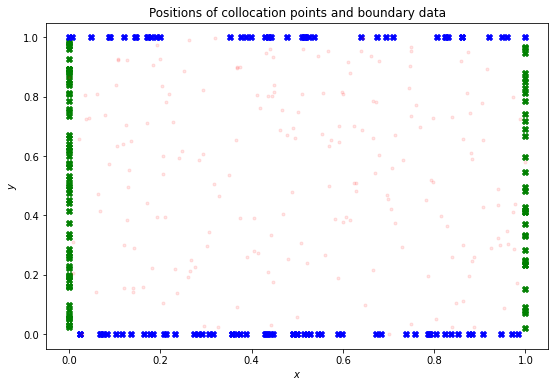

In [ ]:
fig = plt.figure(figsize=(9,6))
plt.scatter(x_1b, y_1b,c='g', marker='X', vmin=-1, vmax=1)
plt.scatter(x_2b, y_2b, c='b', marker='X', vmin=-1, vmax=1)
plt.scatter(x_r, y_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.title('Positions of collocation points and boundary data');

We now do basically the same thing with the test data.

In [ ]:
k_array = np.array([])
for i in tf.random.uniform((1,1), 0.001, 0.001, dtype=DTYPE):
  k_variable =  i.numpy()
  k_array = np.concatenate([k_array, k_variable])

#print(k_array)

In [ ]:
################# test data #################
#build inputs
cont = 0
X_data_d_test = np.array([[0]*3])
u_data_d_test = np.array([[0]*1])
X_data_n_test = np.array([[0]*3])
u_data_n_test = np.array([[0]*1])
X_r_test = np.array([[0]*3])


for i in k_array:
  k_var =  i / 1.
  cont = cont + 1

  ### Define array with k
  ##horizontal
  tensor_k = tf.fill([N_b_x,1], k_var)
  X_1b = tf.concat([tensor_k, x_1b, y_1b], axis=1).numpy()

  ### Define array with k
  ## vertical
  tensor_k = tf.fill([N_b_y,1], k_var)
  X_2b = tf.concat([tensor_k, x_2b, y_2b], axis=1).numpy()

  ### Define array with k
  ## points inside a domain
  tensor_k = tf.fill([N_r,1], k_var)
  X_r = tf.concat([tensor_k,x_r, y_r], axis=1).numpy()


  #### Collect data in lists
  X_data_d_test = np.concatenate([X_data_d_test, X_1b])
  u_data_d_test = np.concatenate([u_data_d_test, u_1b])
  X_data_n_test = np.concatenate([X_data_n_test, X_2b])
  u_data_n_test = np.concatenate([u_data_n_test, u_2b])
  X_r_test = np.concatenate([X_r_test, X_r])

X_data_d_test = np.delete(X_data_d_test, 0, 0)
u_data_d_test = np.delete(u_data_d_test, 0, 0)
X_data_n_test = np.delete(X_data_n_test, 0, 0)
u_data_n_test = np.delete(u_data_n_test, 0, 0)
X_r_test = np.delete(X_r_test, 0, 0)

X_data_d_test = tf.convert_to_tensor(X_data_d_test, dtype=DTYPE)
X_data_n_test = tf.convert_to_tensor(X_data_n_test, dtype=DTYPE)
X_r_test = tf.convert_to_tensor(X_r_test, dtype=DTYPE)
u_data_d_test = tf.convert_to_tensor(u_data_d_test, dtype=DTYPE)
u_data_n_test = tf.convert_to_tensor(u_data_n_test, dtype=DTYPE)

In [ ]:
def custom_activation(x):
    #alpha_f = tf.sqrt(sigma/eps)
    return (1.+ tf.exp(x/(np.sqrt(6))))**(-2)

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

## Setup model problem with the NN

In [ ]:
# Initialize model aka u_\theta
# Input is three-dimensional (k + x + y dimension)
# Output is one-dimensional
NN = init_NN(num_inputs=3, num_outputs=1)
model = RAD(NN)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 2000 steps use a learning rate of 0.04
# from 2000 - 10000: learning rate = 0.01
# from 10000 - 20000: learning rate = 0.001
# from 20000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([500,1000,5000,10000],[4e-2,1e-2,1e-3,5e-4,1e-4])
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2000,10000,20000],[4e-2,1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

RAD.set_optimizer(optim)


## Train model

In [ ]:
# Number of training epochs
N = 10000
hist = []
pa = []

# Start timer
t0 = time()

data_list = X_r_train, X_data_d_train, u_data_d_train, X_data_n_train, u_data_n_train

for i in range(N+1):

    loss = model.train_step(data_list)

    # Append current loss to hist

    hist.append([loss[0].numpy(), loss[1].numpy(), loss[2].numpy()])
    pa.append(i)

    # Output current loss after 50 iterates
    if i%100 == 0:
        print('It {:05d}: loss = [{:10.8e}, {:10.8e}, {:10.8e}]'.format(i,loss[0],loss[1],loss[2]))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = [1.06193472e+00, 6.91619334e-02, 1.01159790e-01]
It 00100: loss = [8.20317660e-02, 6.51763760e-02, 8.03374908e-04]
It 00200: loss = [1.67551489e-01, 1.50862395e-01, 2.78010803e-04]
It 00300: loss = [7.43046798e-02, 2.23216718e-01, 9.51965904e-05]
It 00400: loss = [3.14018232e-01, 1.34489201e-01, 2.02420319e-04]
It 00500: loss = [8.97620537e-02, 7.81695620e-03, 6.24593061e-04]
It 00600: loss = [2.95087318e-02, 1.63856974e-03, 1.25491376e-04]
It 00700: loss = [2.85456676e-02, 1.25117850e-03, 9.60975579e-05]
It 00800: loss = [2.81279461e-02, 1.18531184e-03, 7.12669315e-05]
It 00900: loss = [2.78621431e-02, 1.20677148e-03, 5.46261343e-05]
It 01000: loss = [2.76645552e-02, 1.23880057e-03, 4.46301823e-05]
It 01100: loss = [2.76446933e-02, 1.24184967e-03, 4.38327732e-05]
It 01200: loss = [2.76254216e-02, 1.24471303e-03, 4.30998432e-05]
It 01300: loss = [2.76050901e-02, 1.24764568e-03, 4.23688964e-05]
It 01400: loss = [2.75836841e-02, 1.25062557e-03, 4.16460708e-05]
It 01500: 

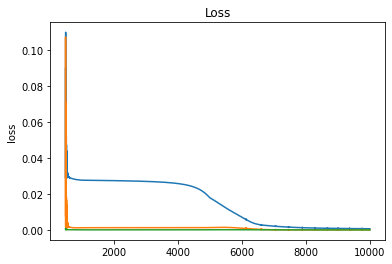

In [ ]:
# plotting the points
plt.plot(pa[500:], hist[500:])

# naming the y axis
plt.ylabel('loss')

# giving a title to my graph
plt.title('Loss')

# function to show the plot
plt.show()

In [ ]:
aux_dados_test = np.concatenate((X_r_test, X_data_d_test, X_data_n_test))

k, x, y = aux_dados_test[:,0:1], aux_dados_test[:,1:2], aux_dados_test[:,2:3]
inputs_test = tf.stack([k[:,0],x[:,0], y[:,0]], axis=1)

u = model.NN(inputs_test)

## Exact Solution

In [ ]:
#solution sigma != 0 and alpha == 0

def exact(inputs):
    eps= inputs[:,0]
    x = inputs[:, 1]
    y = inputs[:, 2]
    tf.math.sinh(x, name=None)

    auxf = (np.sqrt(4 * eps * model.sigma)) / (2*eps)

    u = (np.sinh(auxf * (x-1)) - np.sinh(auxf * (x)))/(np.sinh(auxf)) + 1

    return u


In [ ]:
#solution sigma = 0 and alpha != 0

def exact(inputs):
    eps= inputs[:,0]
    x = inputs[:, 1]
    y = inputs[:, 2]

    aux = (model.alphax) / (2.*eps)
    print (aux.dtype)
    print (x.dtype)
    # print (model.alphax)

    u = (1./model.alphax) * ( x - ((np.sinh(aux * (x)) / np.sinh(aux)) * ( np.exp(aux * (x-1)) )) )

    return u

## Test and evaluate

Error Test 1: 0.6134345618032988
Relative Error Test 1 : 0.7413555284441764
Error Test 2 : 0.4195982651940443
Relative Error Test 2: 14.82711056888353
MSE: 0.0010674607820104478
Max: 0.11054534260537463
Min: 6.803357930351694e-05
Explained Variance Score: 0.9961136171357436


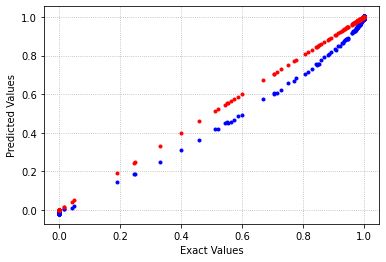

In [ ]:
compute_generalization_error(u, uex)

## Plot solution with regular mesh

In [ ]:
# Set up meshgrid
N = 500
xspace = np.linspace(lb[0], ub[0], N + 1)
yspace = np.linspace(lb[1], ub[1], N + 1)

target_kappa = np.float64(0.001)

X, Y = np.meshgrid( xspace, yspace)

def inputs_meshgrid_regular(k_var):


  Xgrid = np.vstack([X.flatten(),Y.flatten()]).T

  array_k = tf.fill([len(Xgrid),1], k_var).numpy()

  inputs_new = tf.stack([array_k[:,0],Xgrid[:,0], Xgrid[:,1]], axis=1)
  return inputs_new

# Determine predictions of u(x, y)


inputs_new = inputs_meshgrid_regular(target_kappa)
upred = model.NN(inputs_new)
#upred = model(Dados_test)

# Reshape upred
U = upred.numpy().reshape(len(X),len(Y))

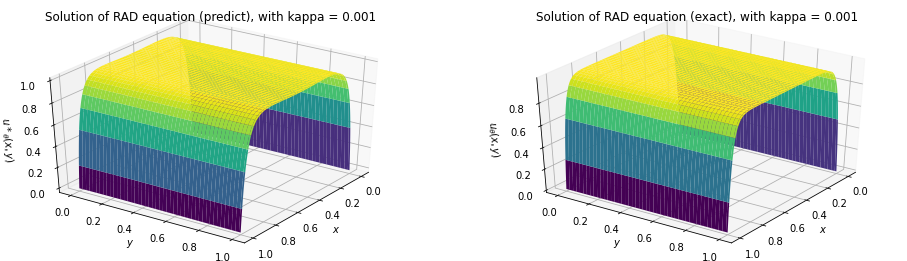

In [ ]:
fig = plt.figure(figsize=(16,10))
# Surface plot of solution u(t,x)
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(X, Y, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$u*_\\theta(x,y)$')
ax.set_title(f'Solution of RAD equation (predict), with kappa = {target_kappa}');

# Surface plot of solution u(t,x)
ax = fig.add_subplot(222, projection='3d')
ax.plot_surface(X, Y, U_ex, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$u_\\theta(x,y)$')
ax.set_title(f'Solution of RAD equation (exact), with kappa = {target_kappa}');

Text(0, 0.5, '$y$')

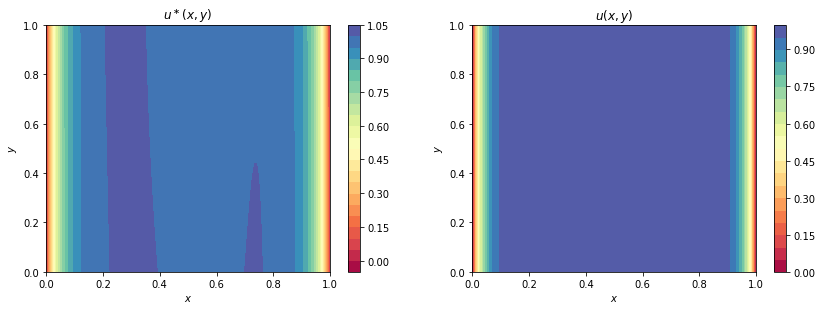

In [ ]:
plt.figure(figsize=(14,10))
plt.subplot(221)
plt.title(r'$u^\ast(x,y)$')
plt.contourf(X, Y, U, 20, cmap='Spectral')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')


plt.subplot(222)
plt.title(r'$u(x,y)$')
ax = plt.gca()
ttl = ax.title
plt.contourf(X, Y, U_ex, 20, cmap='Spectral')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

Text(0, 0.5, '$y$')

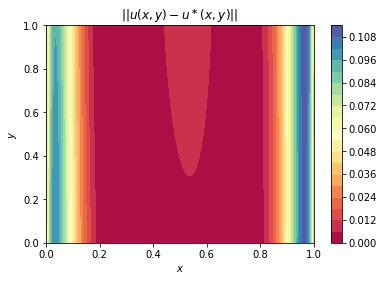

In [ ]:
plt.figure()
plt.title(r'$||u(x,y) - u^\ast(x,y)||$')
ax = plt.gca()
ttl = ax.title
plt.contourf(X, Y, np.sqrt((U_ex-U)**2), 20, cmap='Spectral')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

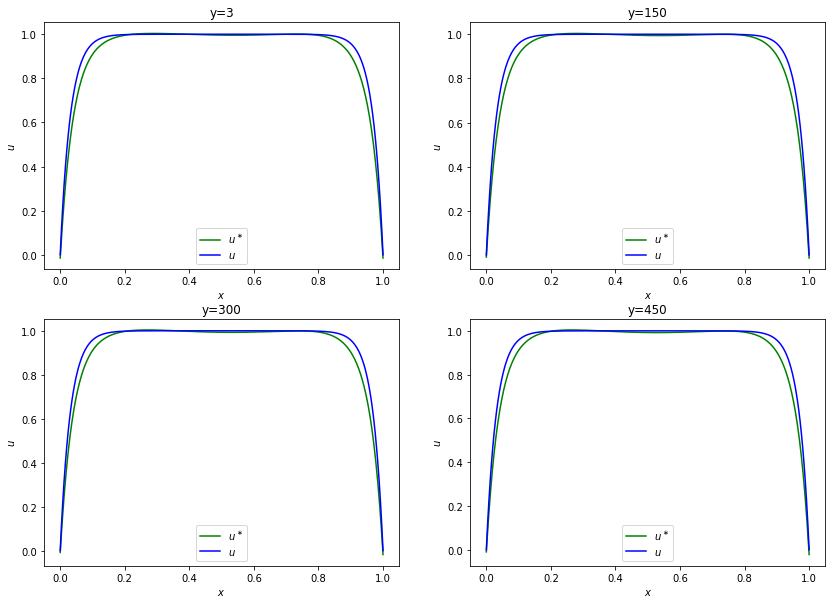

In [ ]:
plt.figure(figsize=(14,10))
plt.subplot(221)
plt.plot(X[3, :], U[3,:],c='g', label=r'$u^\ast$')
plt.plot(X[3, :], U_ex[3,:], c='b', label = r'$u$')
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('y=3')
plt.legend()

plt.subplot(222)
plt.plot(X[150, :], U[150,:],c='g', label=r'$u^\ast$')
plt.plot(X[150, :], U_ex[150,:], c='b', label = r'$u$')
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('y=150')
plt.legend()

plt.subplot(223)
plt.plot(X[300, :], U[300,:],c='g', label=r'$u^\ast$')
plt.plot(X[300, :], U_ex[300,:], c='b', label = r'$u$')
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('y=300')
plt.legend()

plt.subplot(224)
plt.plot(X[450, :], U[450,:],c='g', label=r'$u^\ast$')
plt.plot(X[450, :], U_ex[450,:], c='b', label = r'$u$')
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('y=450')
plt.legend()

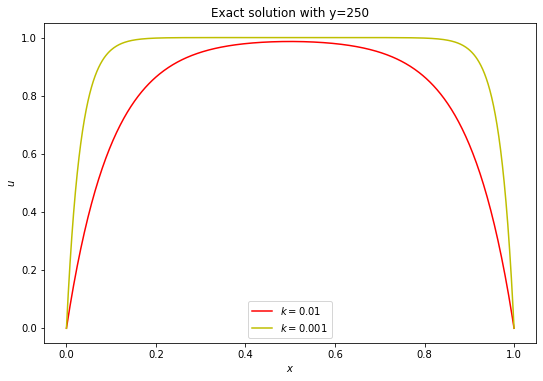

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(333)
#plt.plot(X[250, :], exact(tf.cast(inputs_meshgrid_regular(1.), dtype=tf.float64)).numpy().reshape(len(X),len(Y))[350,:], c='b', label = r'$k = 1 $')
#plt.plot(X[250, :], exact(tf.cast(inputs_meshgrid_regular(0.1), dtype=tf.float64)).numpy().reshape(len(X),len(Y))[350,:], c='g', label = r'$k = 0.1$')
plt.plot(X[250, :], exact(tf.cast(inputs_meshgrid_regular(0.01), dtype=tf.float64)).reshape(len(X),len(Y))[350,:], c='r', label = r'$k = 0.01$')
plt.plot(X[250, :], exact(tf.cast(inputs_meshgrid_regular(0.001), dtype=tf.float64)).reshape(len(X),len(Y))[350,:], c='y', label = r'$k = 0.001$')
#plt.plot(X[250, :], exact(tf.cast(inputs_meshgrid_regular(0.0001), dtype=tf.float64)).numpy().reshape(len(X),len(Y))[350,:], c='m', label = r'$k = 0.0001$')
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Exact solution with y=250')
plt.legend()



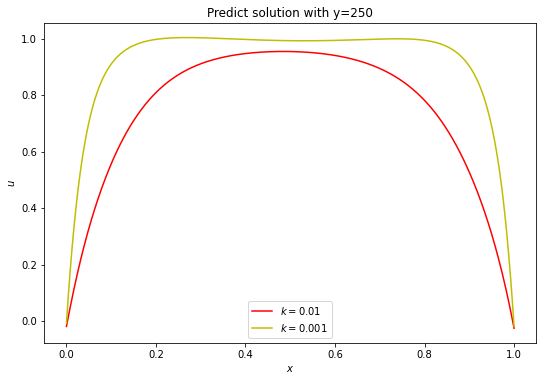

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(333)
#plt.plot(X[250, :], model.NN(inputs_meshgrid_regular(1.)).numpy().reshape(len(X),len(Y))[350,:], c='b', label = r'$k = 1 $')
#plt.plot(X[250, :], model.NN(inputs_meshgrid_regular(0.1)).numpy().reshape(len(X),len(Y))[350,:], c='g', label = r'$k = 0.1$')
plt.plot(X[250, :], model.NN(inputs_meshgrid_regular(0.01)).numpy().reshape(len(X),len(Y))[350,:], c='r', label = r'$k = 0.01$')
plt.plot(X[250, :], model.NN(inputs_meshgrid_regular(0.001)).numpy().reshape(len(X),len(Y))[350,:], c='y', label = r'$k = 0.001$')
#plt.plot(X[250, :], model.NN(inputs_meshgrid_regular(0.0001)).numpy().reshape(len(X),len(Y))[350,:], c='m', label = r'$k = 0.0001$')
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Predict solution with y=250')
plt.legend()

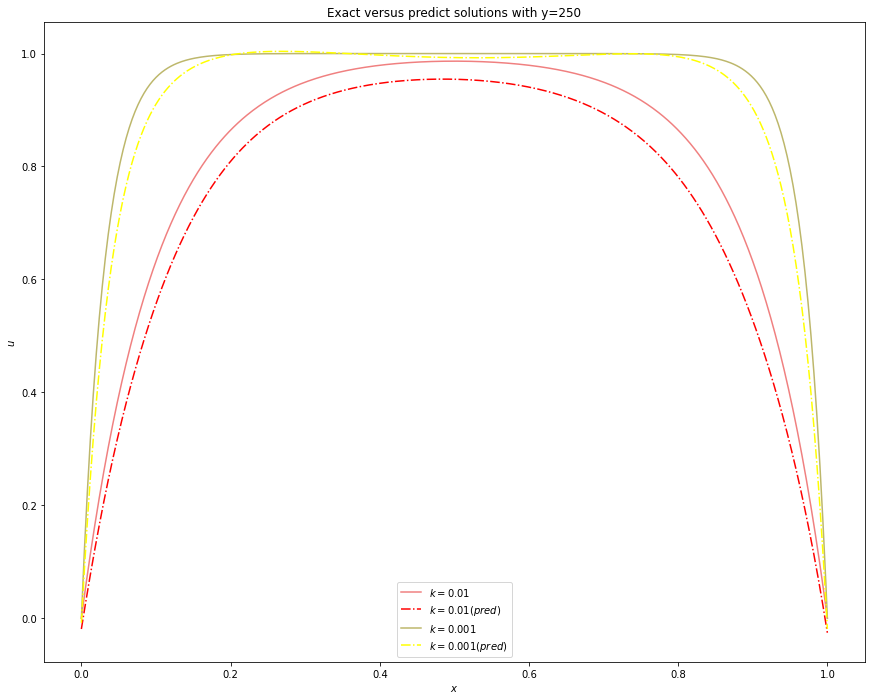

In [ ]:
plt.figure(figsize=(50,40))
plt.subplot(333)
#plt.plot(X[250, :], exact(tf.cast(inputs_meshgrid_regular(1.), dtype=tf.float64)).numpy().reshape(len(X),len(Y))[350,:], c='c', label = r'$k = 1 $')
#plt.plot(X[250, :], model.NN(inputs_meshgrid_regular(1.)).numpy().reshape(len(X),len(Y))[350,:], '-.', c='b',  label = r'$k = 1 (pred)$')
#plt.plot(X[250, :], exact(tf.cast(inputs_meshgrid_regular(0.1), dtype=tf.float64)).numpy().reshape(len(X),len(Y))[350,:], c='lightgreen', label = r'$k = 0.1$')
#plt.plot(X[250, :], model.NN(inputs_meshgrid_regular(0.1)).numpy().reshape(len(X),len(Y))[350,:], '-.', c='g', label = r'$k = 0.1 (pred)$')
plt.plot(X[250, :], exact(tf.cast(inputs_meshgrid_regular(0.01), dtype=tf.float64)).reshape(len(X),len(Y))[350,:], c='lightcoral', label = r'$k = 0.01$')
plt.plot(X[250, :], model.NN(inputs_meshgrid_regular(0.01)).numpy().reshape(len(X),len(Y))[350,:], '-.', c='r', label = r'$k = 0.01 (pred)$')
plt.plot(X[250, :], exact(tf.cast(inputs_meshgrid_regular(0.001), dtype=tf.float64)).reshape(len(X),len(Y))[350,:], c='darkkhaki', label = r'$k = 0.001$')
plt.plot(X[250, :], model.NN(inputs_meshgrid_regular(0.001)).numpy().reshape(len(X),len(Y))[350,:],'-.', c='yellow', label = r'$k = 0.001 (pred)$')
#plt.plot(X[250, :], exact(tf.cast(inputs_meshgrid_regular(0.0001), dtype=tf.float64)).numpy().reshape(len(X),len(Y))[350,:], c='m', label = r'$k = 0.0001$')
#plt.plot(X[250, :], model.NN(inputs_meshgrid_regular(0.0001)).numpy().reshape(len(X),len(Y))[350,:],'-.',  c='magenta', label = f'k = 0.0001 (pred)')
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Exact versus predict solutions with y=250')
plt.legend()
